# Jupyter notebook based on ImageD11 to process scanning 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 16/01/2024

In [1]:
# There is a bug with the current version of ImageD11 in the site-wide Jupyter env.
# This has been fixed here: https://github.com/FABLE-3DXRD/ImageD11/commit/4af88b886b1775585e868f2339a0eb975401468f
# Until a new release has been made and added to the env, we need to get the latest version of ImageD11 from GitHub
# Put it in your home directory
# USER: Change the path below to point to your local copy of ImageD11:

import os

username = os.environ.get("USER")

id11_code_path = f"/home/esrf/{username}/Code/ImageD11"

import sys

sys.path.insert(0, id11_code_path)

In [2]:
# import functions we need

import os, glob, pprint
import numpy as np
import h5py
from tqdm.notebook import tqdm

import matplotlib
%matplotlib widget
from matplotlib import pyplot as plt

import utils

import ImageD11.grain
import ImageD11.indexing
import ImageD11.columnfile
from ImageD11.sinograms import properties, dataset

from ImageD11.blobcorrector import eiger_spatial

In [3]:
# NEW DATASETS

### USER: specify your experimental directory

base_dir = "/data/visitor/ma5837/id11/20240208"

rawdata_path = os.path.join(base_dir, 'RAW_DATA')

!ls -lrt {rawdata_path}

processed_data_root_dir = os.path.join(base_dir, 'PROCESSED_DATA')  # USER: modify this to change the destination folder if desired

total 2941
drwxr-x---  3 opid11 id11    4096 Feb  7 13:36 nanox_test
drwxr-x---  3 opid11 id11    4096 Feb  7 17:05 nanox_test_02_HC
drwxr-x---  3 opid11 id11    4096 Feb  7 17:34 nanox_test_no_sample
drwxr-x---  3 opid11 id11    4096 Feb  8 08:25 sample
drwxr-x---  3 opid11 id11    4096 Feb  8 08:26 test_stress_session
drwxr-x---  3 opid11 id11    4096 Feb  8 09:26 S06
drwxr-x--- 16 opid11 id11    4096 Feb  8 14:57 S20
drwxr-x---  3 opid11 id11    4096 Feb  8 16:26 S11
drwxr-x---  3 opid11 id11    4096 Feb  8 17:17 S05
drwxr-x--- 20 opid11 id11    4096 Feb  8 21:18 S20_HC1
drwxr-x--- 13 opid11 id11    4096 Feb  9 08:38 S18
drwxr-x---  3 opid11 id11    4096 Feb  9 10:14 empty_no_sample
drwxr-x--- 12 opid11 id11    4096 Feb  9 10:54 S17
drwxr-x--- 12 opid11 id11    4096 Feb  9 12:34 S16
drwxr-x---  2 opid11 id11    4096 Feb  9 13:59 test_fatigue_curvesave
drwxr-x---  2 opid11 id11    4096 Feb  9 14:11 S18_HC_fatigue_plots
drwxr-x---  2 opid11 id11    4096 Feb  9 14:47 S17_fatigue_plots


In [4]:
# USER: pick a sample and a dataset you want to segment

sample = "S12"
dataset = "FF_zeries_0"

# USER: specify path to detector mask

mask_path = '/data/id11/inhouse1/ewoks/detectors/files/Frelon2k_C36/mask.edf'

In [5]:
# desination of H5 files

dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")

# USER: specify the path to the parameter file

parfile = 'Fe_refined.par'
spline_file = '/data/id11/inhouse1/ewoks/detectors/files/Frelon2k_C36/frelon36.spline'

In [6]:
# load the dataset from file

ds = ImageD11.sinograms.dataset.load(dset_path)

print(ds)
print(ds.shape)

dataroot = "/data/visitor/ma5837/id11/20240208/RAW_DATA"
analysisroot = "/data/visitor/ma5837/id11/20240208/PROCESSED_DATA"
sample = "S12"
dset = "FF_zeries_0"
shape = ( 1, 1440)
# scans 1 from 1.1 to 1.1
(1, 1440)


In [7]:
# load 3d columnfile from disk

cf_3d = ImageD11.columnfile.colfile_from_hdf(ds.col3dfile)

cf_3d.parameters.loadparameters(parfile)
cf_3d.updateGeometry()

if "index" not in cf_3d.titles:
    cf_3d.addcolumn(np.arange(cf_3d.nrows), "index")

In [8]:
# load 2d columnfile from disk

cf_2d = ImageD11.columnfile.colfile_from_hdf(ds.col2dfile)

cf_2d.parameters.loadparameters(parfile)
cf_2d.updateGeometry()

In [9]:
# load grains from disk

def read_grains(ds):
    with h5py.File(ds.grainsfile, 'r') as hin:      
        grains_group = 'grains'
        
        grains = []
        for gid_string in tqdm(sorted(hin[grains_group].keys(), key=lambda x: int(x))):
            gg = hin[grains_group][gid_string]
            ubi = gg.attrs['ubi'][:]
            translation = gg.attrs['translation'][:]
            g = ImageD11.grain.grain(ubi, translation=translation)
            g.gid = int(gid_string)
            g.peaks_3d = gg['peaks_3d_indexing'][:]
            grains.append(g)
    
    return grains

In [10]:
grains = read_grains(ds)

  0%|          | 0/452 [00:00<?, ?it/s]

In [11]:
# pick a grain and look at its 3D peaks

In [12]:
selected_grain = sorted(grains, key=lambda g: len(g.peaks_3d), reverse=True)[0]

grain1_3d_mask = np.isin(cf_3d.index, selected_grain.peaks_3d)

cf_3d_grain1 = cf_3d.copy()
cf_3d_grain1.filter(grain1_3d_mask)

# cf_3d_grain1 now contains only the 3D peaks for our selected grain

In [13]:
# let's look at the corresponding 2D peaks for the 3D grain

grain1_2d_mask = np.isin(cf_2d.spot3d_id, cf_3d_grain1.index)
cf_2d_grain1 = cf_2d.copy()
cf_2d_grain1.filter(grain1_2d_mask)

In [14]:
print(cf_3d_grain1.nrows)  # number of 3D peaks for this grain
print(cf_2d_grain1.nrows)  # number of 2D peaks for this grain

535
1525


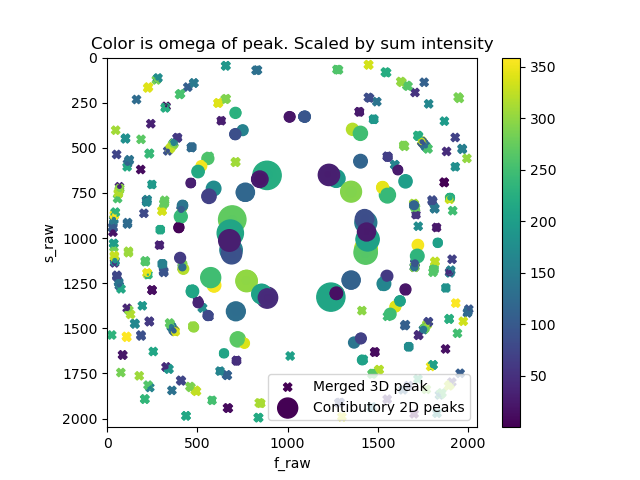

In [15]:
fig, ax = plt.subplots()
ax.scatter(cf_3d_grain1.fc, cf_3d_grain1.sc, marker="X", c=cf_3d_grain1.omega, label='Merged 3D peak')
cols = ax.scatter(cf_2d_grain1.fc, cf_2d_grain1.sc, c=cf_2d_grain1.o_raw, s=cf_2d_grain1.s_I / 1000, label='Contibutory 2D peaks')
fig.colorbar(cols)
ax.set_xlim(0, 2048)
ax.set_ylim(0, 2048)
ax.invert_yaxis()
ax.legend()
ax.set_title("\nColor is omega of peak. Scaled by sum intensity")
ax.set_xlabel("f_raw")
ax.set_ylabel("s_raw")
ax.set_aspect(1)
plt.show()

In [16]:
# better thing is a slider
# iterate over the frames
# sort frame order by omega using numpy argsort
# get the frame number
# get the omega value from ds.omega sorted
# get the corresponding 3D peaks
# get the 2D peaks from that

In [17]:
# get the 2D frame with the most peaks from this grain on it

unique, counts = np.unique(cf_2d_grain1.omega, return_counts=True)
hits_dict = dict(zip(unique, counts))
hits_dict_max = sorted(hits_dict.items(), key=lambda x: x[1], reverse=True)[0]

max_omega, peaks_on_frame = hits_dict_max

omega_mask = cf_2d_grain1.omega == max_omega

fast, slow, omega = cf_2d_grain1.f_raw[omega_mask], cf_2d_grain1.s_raw[omega_mask], cf_2d_grain1.omega[omega_mask]

# print(fast, slow, omega)

# get the corresponding frame number

omegas_sorted = np.sort(ds.omega)[0]
omega_slop = np.round(np.diff(omegas_sorted).mean(), 3)

frame_number = np.where(np.isclose(ds.omega[0, :], max_omega, atol=omega_slop/10))[0][0]

# get the corresponding 2D frame
with h5py.File(ds.masterfile, 'r') as h5In:
    frame_2d = h5In['1.1/measurement/frelon3'][frame_number].astype('uint16')

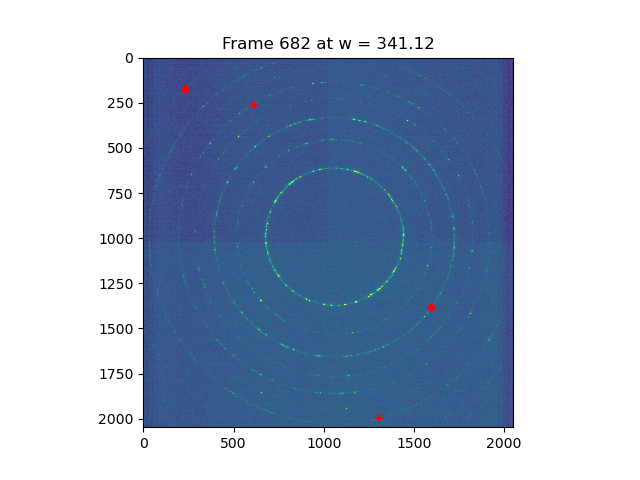

In [18]:
# plot it

from matplotlib.colors import LogNorm

fig, ax = plt.subplots()
ax.imshow(frame_2d, norm=LogNorm(vmax=1000), interpolation="nearest")
ax.scatter(fast, slow, marker='+', c="r")
ax.set_title(f"Frame {frame_number} at w = {max_omega:.2f}")
plt.show()

In [19]:
# Guide to what the 2D peaks columns mean, from ImageD11/src/blobs.h:

# s_1 = 0, /* 1 Npix */
# s_I,     /* 2 Sum intensity */
# s_I2,    /* 3 Sum intensity^2 */
# s_fI,    /* 4 Sum f * intensity */
# s_ffI,   /* 5 Sum f * f* intensity */
# s_sI,    /* 6 Sum s * intensity */
# s_ssI,   /* 7 Sum s * s * intensity */
# s_sfI,   /* 8 Sum f * s * intensity */
# s_oI,    /* 9 sum omega * intensity */
# s_ooI,   /* 10 sum omega2 * intensity */
# s_soI,   /* 11 sum omega * s * intensity */
# s_foI,   /* 12 sum omega * f * intensity */

# mx_I,   /* 13 Max intensity */
# mx_I_f, /* 14 fast at Max intensity */
# mx_I_s, /* 15 slow at Max intensity */
# mx_I_o, /* 16 omega at max I */

# bb_mx_f, /* 17 max of f */
# bb_mx_s, /* 18 max of s */
# bb_mx_o, /* 19 max of omega */
# bb_mn_f, /* 20 min of f */
# bb_mn_s, /* 21 min of s */
# bb_mn_o, /* 22 min of o */

# avg_i, /* Average intensity */
# f_raw, /* fast centre of mass */
# s_raw, /* slow centre of mass */
# o_raw, /* omega centre of mass */
# m_ss,  /* moments */
# m_ff,
# m_oo,
# m_sf,
# m_so,
# m_fo,

In [20]:
# peak "aspect ratio" could be considered the ratio between bounding box size in fast and slow direction

cf_2d_grain1.addcolumn(cf_2d_grain1.bb_mx_f - cf_2d_grain1.bb_mn_f, "bb_size_f")
cf_2d_grain1.addcolumn(cf_2d_grain1.bb_mx_s - cf_2d_grain1.bb_mn_s, "bb_size_s")
cf_2d_grain1.addcolumn(cf_2d_grain1.bb_size_f / cf_2d_grain1.bb_size_s, "bb_aspect")

/tmp/ipykernel_566804/3443681949.py:5: RuntimeWarning: divide by zero encountered in divide
  cf_2d_grain1.addcolumn(cf_2d_grain1.bb_size_f / cf_2d_grain1.bb_size_s, "bb_aspect")


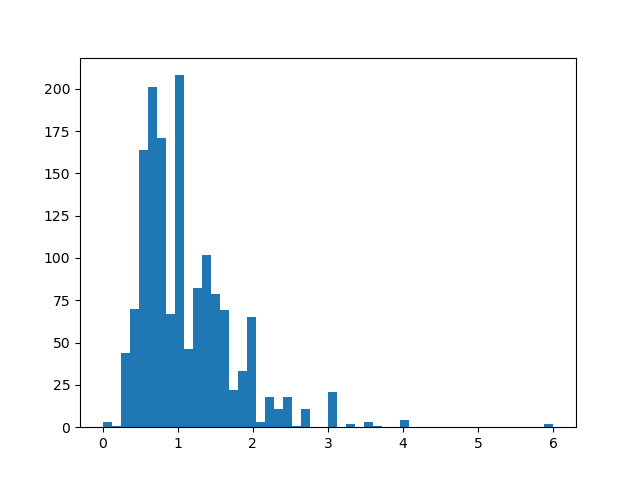

In [21]:
fig, ax = plt.subplots()
ax.hist(cf_2d_grain1.bb_aspect[cf_2d_grain1.bb_aspect != np.inf], bins=50)
plt.show()

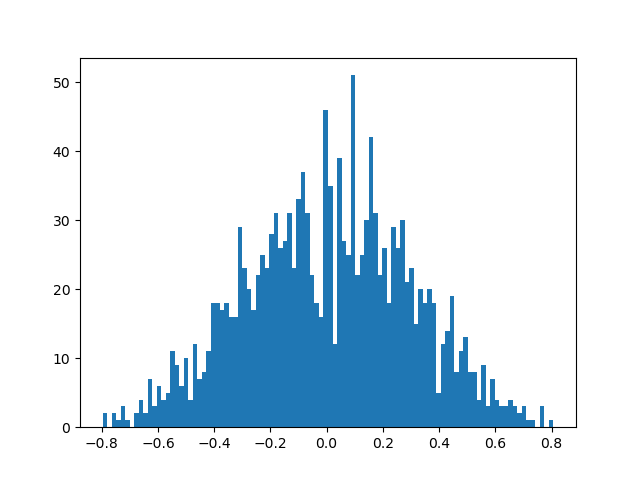

In [22]:
# the problem here is it depends where on the ring you are
# perhaps moment between slow and fast is a better metric

fig, ax = plt.subplots()
ax.hist(cf_2d_grain1.m_sf, bins=100)
plt.show()

In [23]:
# construct a mean moment for each grain

for grain in tqdm(grains):
    grain1_3d_mask = np.isin(cf_3d.index, grain.peaks_3d)

    cf_3d_grain1 = cf_3d.copy()
    cf_3d_grain1.filter(grain1_3d_mask)

    grain1_2d_mask = np.isin(cf_2d.spot3d_id, cf_3d_grain1.index)
    cf_2d_grain1 = cf_2d.copy()
    cf_2d_grain1.filter(grain1_2d_mask)
    
    grain.cf_3d = cf_3d_grain1
    grain.cf_2d = cf_2d_grain1

  0%|          | 0/452 [00:00<?, ?it/s]

In [24]:
for grain in grains:
    grain.mean_sf_moment = np.abs(np.mean(grain.cf_2d.m_sf))

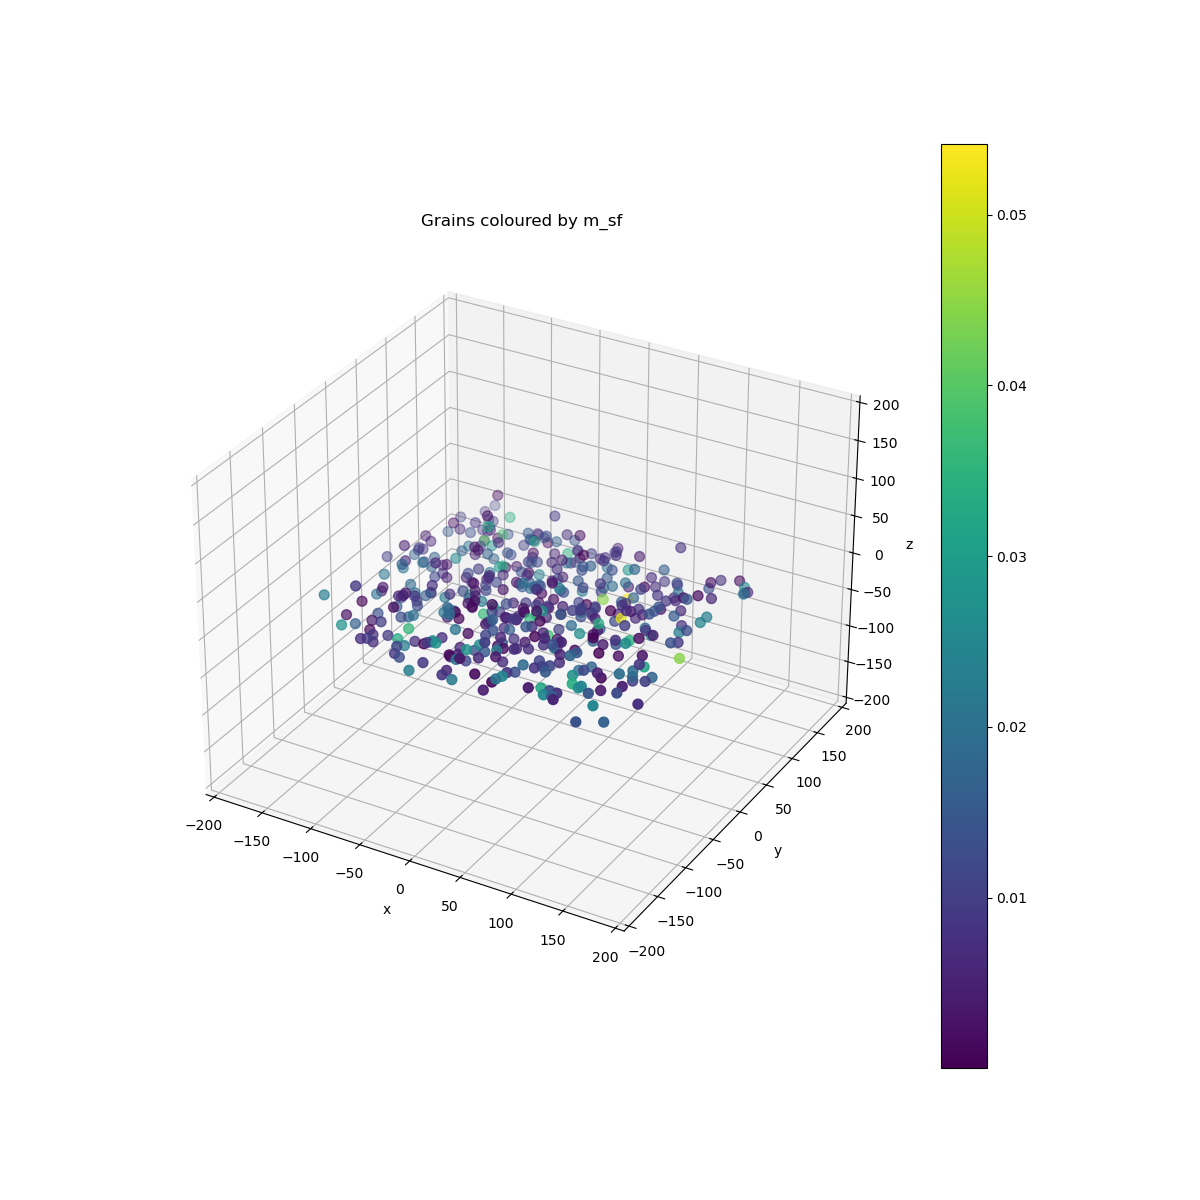

In [25]:
centre_plot = False

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
xx = [grain.translation[0] for grain in grains]
yy = [grain.translation[1] for grain in grains]
zz = [grain.translation[2] for grain in grains]
col = [grain.mean_sf_moment for grain in grains]
sizes = [0.0001*(cf_3d.nrows) for grain in grains]
if centre_plot:
    scatterplot = ax.scatter(xx-np.mean(xx), yy-np.mean(yy), zz, c=col, s=sizes)
else:
    scatterplot = ax.scatter(xx, yy, zz, c=col, s=sizes)
ax.set_xlim(-200,200)
ax.set_ylim(-200,200)
ax.set_zlim(-200,200)
plt.colorbar(scatterplot)
ax.set_title("Grains coloured by m_sf")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [26]:
# perhaps something else
# like - the mean number of 2d peaks per merged 3d peak?
# gives a terrible rough approximation for omega spread

In [27]:
for grain in grains:
    spots_3d, merge_counts = np.unique(grain.cf_2d.spot3d_id, return_counts=True)
    grain.mean_merges = np.mean(merge_counts)

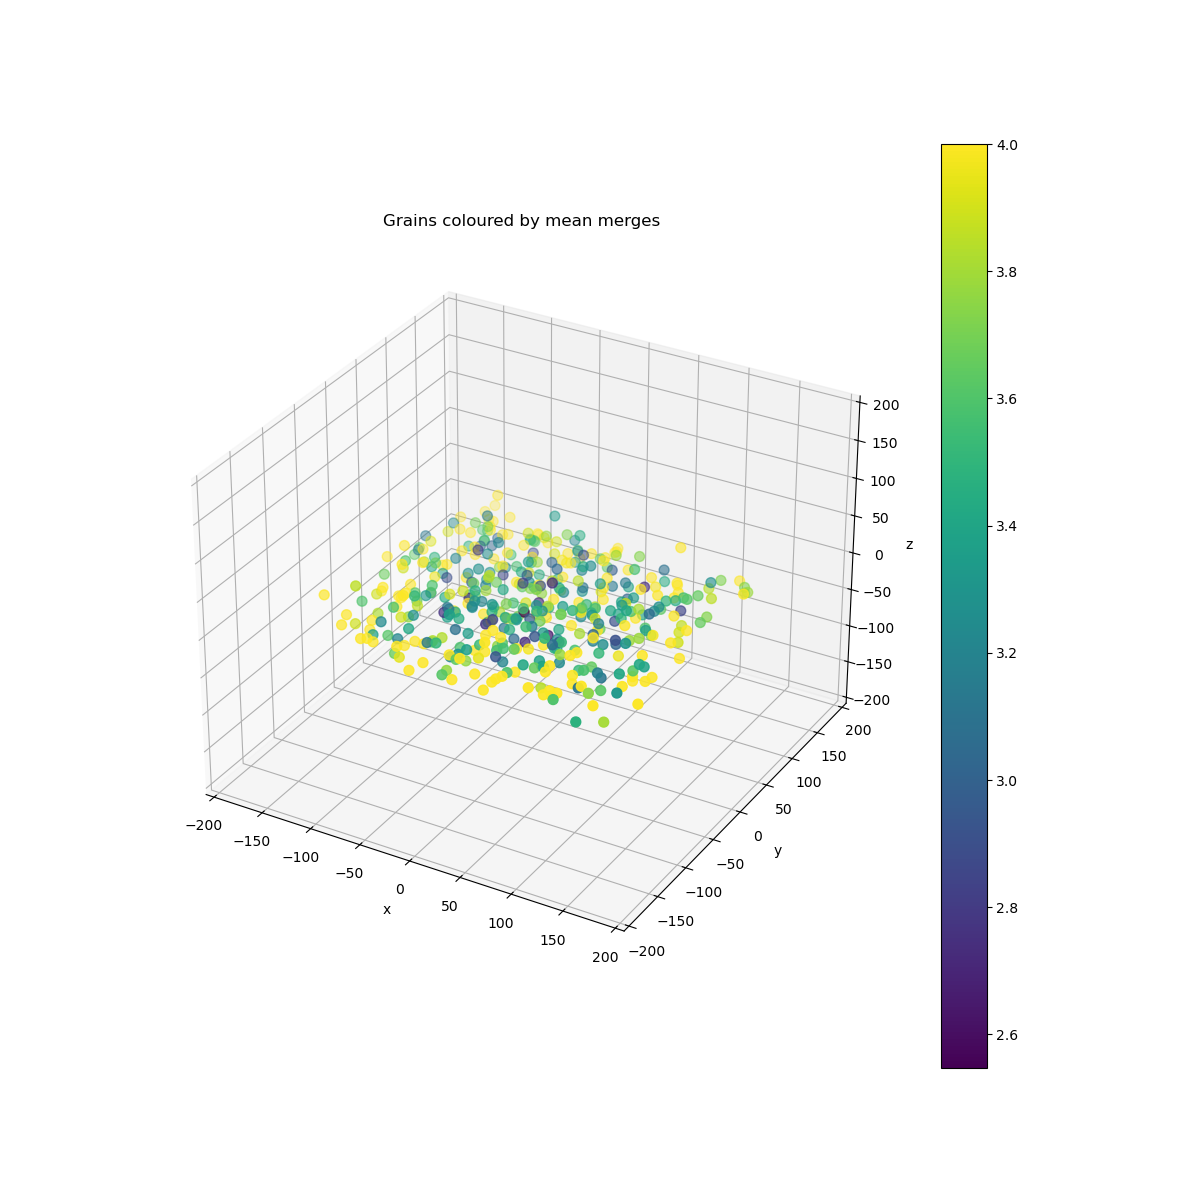

In [28]:
centre_plot = False

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
xx = [grain.translation[0] for grain in grains]
yy = [grain.translation[1] for grain in grains]
zz = [grain.translation[2] for grain in grains]
col = [grain.mean_merges for grain in grains]
sizes = [0.0001*(cf_3d.nrows) for grain in grains]
if centre_plot:
    scatterplot = ax.scatter(xx-np.mean(xx), yy-np.mean(yy), zz, c=col, s=sizes, vmax=4)
else:
    scatterplot = ax.scatter(xx, yy, zz, c=col, s=sizes, vmax=4)
ax.set_xlim(-200,200)
ax.set_ylim(-200,200)
ax.set_zlim(-200,200)
plt.colorbar(scatterplot)
ax.set_title("Grains coloured by mean merges")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()